# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

#### Importing Libraries and Modules

In [298]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc

from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

from sklearn.preprocessing import MinMaxScaler



#### Loading and Preparing Data

In [299]:
# Data loading
df = pd.read_csv('data.csv')

In [300]:
# Filling in missing values
df['embarked'] = df['embarked'].fillna('S')
df['fare'] = df['fare'].fillna(df['fare'].mean())
df['age'] = df.groupby(['sex'], sort=False)['age'].apply(lambda x: x.fillna(x.mean())).reset_index(level=0, drop=True)


In [301]:
# Conversion of categorical variables
df['sex'] = pd.factorize(df['sex'])[0]
df['embarked'] = pd.factorize(df['embarked'])[0]


In [302]:
columns_to_drop = ['name', 'ticket', 'cabin', 'home.dest', 'ID']
df = df.drop(columns=columns_to_drop)

#### Splitting Data into Training, Testing, and Validation Sets

In [303]:
# Separation into training, test and validation samples
df_train_temp, df_temp = train_test_split(df, train_size=0.7, random_state=42, stratify=df['survived'])
df_test, df_val = train_test_split(df_temp, train_size=0.5, random_state=42, stratify=df_temp['survived'])

In [304]:
# We obtain X and y separately for each data set
X_train, y_train = df_train_temp.drop(columns=['survived']), df_train_temp['survived']
X_test, y_test = df_test.drop(columns=['survived']), df_test['survived']
X_val, y_val = df_val.drop(columns=['survived']), df_val['survived']


#### Hyperparameter Tuning and Finding the Best Parameters for Decision Tree

In [305]:
# Parameters for Grid Search
grid = {
    'max_depth': range(5, 12),
    "criterion": ["gini", "entropy", "log_loss"]
}
param_grid = ParameterGrid(grid)

In [306]:
# Finding the best settings
accuracy_lst = []
for args in param_grid:
    tree = DecisionTreeClassifier(**args)
    score = cross_validate(tree, X_train, y_train, cv=3)
    accuracy_lst.append(score['test_score'].mean())

best_args = param_grid[np.argmax(accuracy_lst)]
best_args, max(accuracy_lst)


({'max_depth': 5, 'criterion': 'entropy'}, 0.7728806720223029)

#### Training and Evaluating the Decision Tree Model

In [307]:
# Training a Decision Tree model with better parameters
best_model = DecisionTreeClassifier(**best_args)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [308]:
# Evaluation of the model on test data
test_predict = best_model.predict(X_test)
accuracy = accuracy_score(y_test, test_predict)
f1_score_dt = f1_score(y_test, test_predict)
fpr_dt, tpr_dt, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc_dt = auc(fpr_dt, tpr_dt)


In [309]:

# Results output
print("Decision Tree - Accuracy:", accuracy, "F1 Score:", f1_score_dt, "ROC AUC:", roc_auc_dt)

Decision Tree - Accuracy: 0.7733333333333333 F1 Score: 0.6599999999999999 ROC AUC: 0.8292046936114732


#### Hyperparameter Tuning and Training the KNN Model

In [310]:
# Setting hyperparameters for the KNN model
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance']
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=3, scoring='f1')
grid_search_knn.fit(X_train, y_train)

# Training the KNN model with better parameters
best_knn = grid_search_knn.best_estimator_
best_knn.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=7)

#### Evaluating the KNN Model on Test Data and Comparison with Decision Tree

In [311]:
# Evaluation of the KNN model on test data
knn_predict = best_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, knn_predict)
f1_score_knn = f1_score(y_test, knn_predict)
fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn.predict_proba(X_test)[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Output of results for the KNN model
print("KNN - Accuracy:", accuracy_knn, "F1 Score:", f1_score_knn, "ROC AUC:", roc_auc_knn)

# Comparison of model results
print("\nDecision Tree vs KNN:")
print("Decision Tree - Accuracy:", accuracy ,"F1 Score:", f1_score_dt, "ROC AUC:", roc_auc_dt)
print("KNN - Accuracy:", accuracy_knn ,"F1 Score:", f1_score_knn, "ROC AUC:", roc_auc_knn)


KNN - Accuracy: 0.7266666666666667 F1 Score: 0.594059405940594 ROC AUC: 0.7686720059601415

Decision Tree vs KNN:
Decision Tree - Accuracy: 0.7733333333333333 F1 Score: 0.6599999999999999 ROC AUC: 0.8292046936114732
KNN - Accuracy: 0.7266666666666667 F1 Score: 0.594059405940594 ROC AUC: 0.7686720059601415


#### Feature Scaling and Additional Training of KNN

In [312]:
from sklearn.preprocessing import StandardScaler

# We fit the min-max scaler to the training data
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(X_train)
Xtest_scaled = scaler.fit_transform(X_test)
# We then apply the same transformation to the validation data
Xval_scaled = scaler.transform(X_val)

# We train the model on transformed data
clf = KNeighborsClassifier()
clf.fit(Xtrain_scaled, y_train)

print(f"Validation accuracy of normalized model: {clf.score(Xval_scaled, y_val):0.4f}")


Validation accuracy of normalized model: 0.7533


#### Comparing Models and Visualizing Results

In [313]:
# Training the KNN model and finding the best hyperparameters
grid_search_knn.fit(Xtrain_scaled, y_train)
best_knn = grid_search_knn.best_estimator_

# Predictions on a test dataset
knn_predictions = best_knn.predict(Xtest_scaled)

# Calculation of metrics
f1_score_knn = f1_score(y_test, knn_predictions)
accuracy_knn = accuracy_score(y_test, knn_predictions)
fpr_knn, tpr_knn, _ = roc_curve(y_test, best_knn.predict_proba(Xtest_scaled)[:,1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Results output
print("\nDecision Tree vs KNN:")
print("Decision Tree - Accuracy:", accuracy ,"F1 Score:", f1_score_dt, "ROC AUC:", roc_auc_dt)
print("KNN after normalize - Accuracy:", accuracy_knn ,"F1 Score:", f1_score_knn, "ROC AUC:", roc_auc_knn)



Decision Tree vs KNN:
Decision Tree - Accuracy: 0.7733333333333333 F1 Score: 0.6599999999999999 ROC AUC: 0.8292046936114732
KNN after normalize - Accuracy: 0.7533333333333333 F1 Score: 0.6542056074766355 ROC AUC: 0.8142112125162972


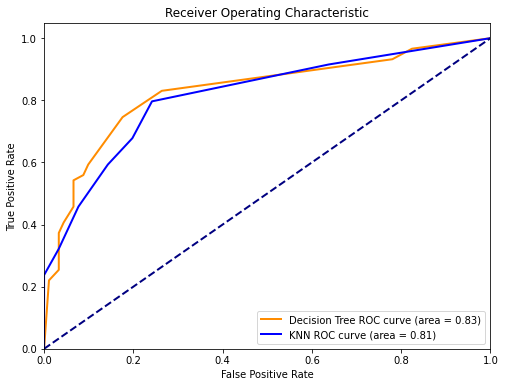

In [314]:
import matplotlib.pyplot as plt

# ROC graph for Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'Decision Tree ROC curve (area = {roc_auc_dt:.2f})')

# ROC graph for KNN
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN ROC curve (area = {roc_auc_knn:.2f})')

# ROC plot for the random model (baseline)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Additional graph settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.show()


- **Accuracy**: *Decision Tree* has an accuracy of 0.7733, slightly higher than that of KNN (0.7533). This indicates that, on average, Decision Tree classifies data more effectively.

- **F1 Score**: *Decision Tree* also has a slightly higher F1 Score (0.66) compared to KNN (0.6542). Since the F1 Score is a more balanced metric that takes into account both precision and recall, this suggests that Decision Tree offers a more balanced combination of false positives and false negatives.

- **ROC AUC**: Both models show similar results in ROC AUC, with a slight advantage for Decision Tree. This suggests that both models have a similar ability to distinguish between classes at different classification thresholds.


#### Evaluating the Model on Validation Data

In [315]:
# Prediction on validation dataset
val_predictions = best_model.predict(X_val)
val_probabilities = best_model.predict_proba(X_val)[:, 1]

# Metrics calculation
val_accuracy = accuracy_score(y_val, val_predictions)
val_f1 = f1_score(y_val, val_predictions)
val_auc = roc_auc_score(y_val, val_probabilities)

# Results output
print(f"Decision Tree - Validation Accuracy: {val_accuracy:.4f}")
print(f"Decision Tree - Validation F1 Score: {val_f1:.4f}")
print(f"Decision Tree - Validation ROC AUC: {val_auc:.4f}")


Decision Tree - Validation Accuracy: 0.7867
Decision Tree - Validation F1 Score: 0.7091
Decision Tree - Validation ROC AUC: 0.8308


#### Preparing and Evaluating Data for External Assessment

In [316]:
# Uploading data for evaluation
df_evaluation = pd.read_csv('evaluation.csv')

df_evaluation['embarked'] = df_evaluation['embarked'].fillna('S')
df_evaluation['fare'] = df_evaluation['fare'].fillna(df['fare'].mean())
df_evaluation['age'] = df_evaluation.groupby(['sex'], sort=False)['age'].apply(lambda x: x.fillna(x.mean())).reset_index(level=0, drop=True)

# Conversion of categorical variables
df_evaluation['sex'] = pd.factorize(df_evaluation['sex'])[0]
df_evaluation['embarked'] = pd.factorize(df_evaluation['embarked'])[0]

columns_to_drop = ['name', 'ticket', 'cabin', 'home.dest']
df_evaluation = df_evaluation.drop(columns=columns_to_drop)

# Save the ID before applying the model
evaluation_ids = df_evaluation['ID'].copy()

# Now you can remove the ID from df_evaluation
df_evaluation = df_evaluation.drop(columns=['ID'])

# Applying the model to obtain predictions
evaluation_predictions = best_model.predict(df_evaluation)

#### Saving and Exporting Prediction Results

In [317]:
# Saving results to a file
results_df = pd.DataFrame({'ID': evaluation_ids, 'survived': evaluation_predictions})
results_df.to_csv('results.csv', index=False)